In [1]:
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations as A
import warnings
import glob
import random
import cv2
import os
import math
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

1. Load and normalize the training and test datasets
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### Load and normalize the training and test datasets

In [2]:
class FruitDatasetFolder(Dataset):
    def __init__(self, path, total_classes, transform=None):
        self.path = path
        self.total_classes = total_classes
        self.transform = transform
        self.img_paths = glob.glob(f"{path}/**/**.jpg") + glob.glob(f"{path}/**/**.png")
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = img_path.split("/")[-2]
        
        if self.transform:
            img = self.transform(image=img)["image"]
        
        return img, self.total_classes.index(label)

In [3]:
training_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(100, 100),
    A.Normalize()
])

val_augmentation = A.Compose([
    A.Resize(100, 100),
    A.Normalize()
])

total_classes = os.listdir("datasets/fruits-360/Training")
total_classes.sort()

CONFIG = {
    "TRAINING_BATCH_SIZE": 128,
    "VAL_BATCH_SIZE": 64,
    "LEARNING_RATE": 0.01,
    "MOMENTUM": 0.9
}

In [4]:
visualization_folder = FruitDatasetFolder("datasets/fruits-360/Training", total_classes)
visualization_set = DataLoader(visualization_folder, batch_size=64, shuffle=True)

In [5]:
unique_img_classes = {}

for batch in visualization_set:
    for index, label in enumerate(batch[1]):
        if total_classes[label] not in unique_img_classes:
            unique_img_classes[total_classes[label]] = batch[0][index]
            
    if len(total_classes) == len(unique_img_classes):
         break

#### Visualize dataset

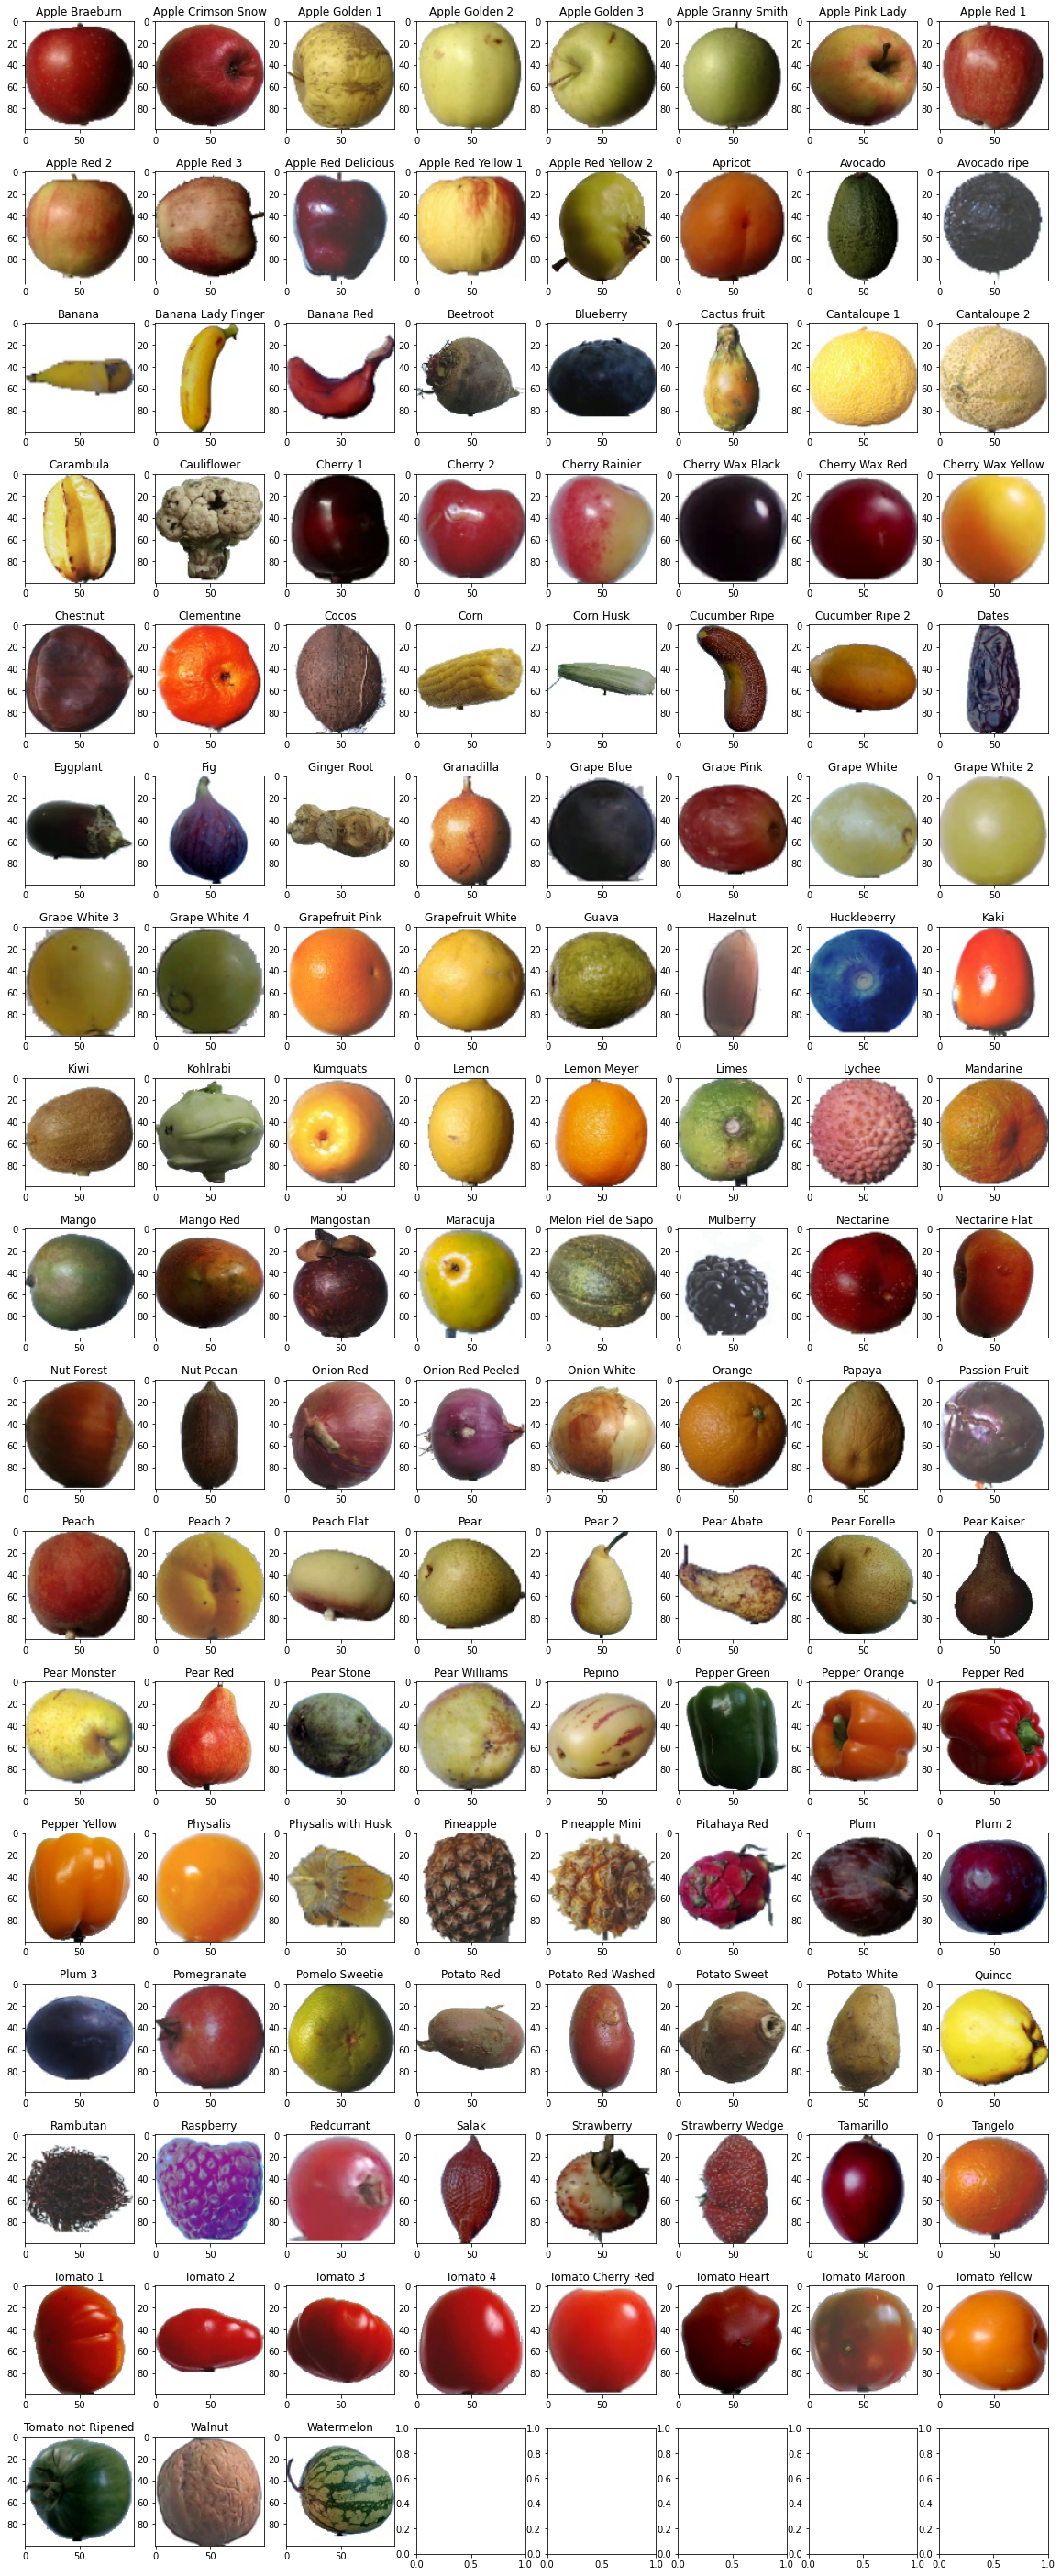

In [6]:
imgs_per_row = 8
total_rows = math.ceil(len(unique_img_classes) / imgs_per_row)
visualize_labels = sorted(list(unique_img_classes.keys()))
index = 0

fig, ax = plt.subplots(total_rows, imgs_per_row, figsize=(20, total_rows * 3))

for row in range(total_rows):
    for col in range(imgs_per_row):
        if index >= len(unique_img_classes):
            break
            
        label = visualize_labels[index]
        ax[row][col].imshow(unique_img_classes[label])
        ax[row][col].set_title(label)
        
        index += 1
        
plt.show()

In [7]:
training_folder = FruitDatasetFolder("datasets/fruits-360/Training", total_classes, training_augmentation)
training_set = DataLoader(training_folder, batch_size=CONFIG["TRAINING_BATCH_SIZE"], shuffle=True)

val_folder = FruitDatasetFolder("datasets/fruits-360/Test", total_classes, val_augmentation)
val_set = DataLoader(val_folder, batch_size=CONFIG["VAL_BATCH_SIZE"], shuffle=True)

### Define a Convolutional Neural Network

For demonstration, I implement VGG-11 for re-ultilizing the VGG layer

![VGG-11](https://imgur.com/uLXrKxe.jpg)

In [8]:
def vgg_layer(num_conv, channel, prev_channel):
    layers = []
    
    for i in range(num_conv):
        layers.append(nn.Conv2d(prev_channel, channel, kernel_size=3, padding=1))  # should we use bias in Convolutional Layer
        layers.append(nn.ReLU())
        prev_channel = channel
        
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    return nn.Sequential(*layers)

In [9]:
class FruitClassification(nn.Module):
    def __init__(self, n_classes: int, use_internet_backbone=True):
        super(FruitClassification, self).__init__()
        
        if use_internet_backbone:
            self.layers = torch.hub.load("pytorch/vision:v0.9.0", "vgg11", pretrained=True)
            self.layers.classifier._modules["6"] = nn.Linear(4096, n_classes)
        else:
            self.layers = nn.Sequential(
                vgg_layer(1, 64, 3),
                vgg_layer(1, 128, 64),
                vgg_layer(2, 256, 128),
                vgg_layer(2, 512, 256),
                vgg_layer(2, 512, 512),
                nn.Flatten(),
                nn.Linear(4608, 4096),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(4096, n_classes),
#                 nn.Softmax(),
            )
        
    def forward(self, img):
        return self.layers(img)

In [10]:
sample_img = torch.zeros(1, 3, 100, 100)

model = FruitClassification(len(total_classes), use_internet_backbone=False)
prediction_result = model(sample_img)

prediction_result.shape, prediction_result

(torch.Size([1, 131]),
 tensor([[ 6.6667e-03,  1.3790e-04,  5.5838e-03,  3.0719e-03, -5.8862e-03,
          -3.5696e-03, -1.2590e-02, -1.8743e-02,  1.1445e-02, -7.7408e-03,
          -3.1410e-03,  7.3645e-04, -9.1067e-03,  5.4795e-03,  1.5428e-02,
          -2.4530e-03,  1.3685e-02, -1.6329e-02, -7.7184e-03,  8.2465e-03,
          -3.4568e-05, -1.0163e-03,  9.4398e-03, -6.4325e-03, -8.3744e-03,
          -1.4535e-02,  5.9789e-03, -9.9044e-03, -4.0903e-03, -8.6711e-03,
           1.3819e-02,  9.4308e-03, -7.0870e-03,  1.0788e-02, -1.7261e-02,
          -1.0634e-02, -5.5559e-03,  8.7236e-03, -6.2743e-03, -4.4444e-03,
           1.4919e-02,  1.2281e-03,  1.6586e-02, -1.2187e-02, -2.1879e-02,
          -1.8019e-02,  6.5341e-03, -5.4001e-03, -1.7135e-02, -2.8241e-03,
          -3.7633e-03, -9.3125e-04, -9.1669e-03,  1.4279e-02, -1.0498e-02,
          -7.2194e-04, -1.7557e-02,  1.8451e-02, -4.1009e-03, -1.1319e-02,
           1.4627e-02, -1.0874e-03,  3.3442e-03, -5.4236e-03, -6.5508e-03,
  

In [11]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,792
              ReLU-2         [-1, 64, 100, 100]               0
         MaxPool2d-3           [-1, 64, 50, 50]               0
            Conv2d-4          [-1, 128, 50, 50]          73,856
              ReLU-5          [-1, 128, 50, 50]               0
         MaxPool2d-6          [-1, 128, 25, 25]               0
            Conv2d-7          [-1, 256, 25, 25]         295,168
              ReLU-8          [-1, 256, 25, 25]               0
            Conv2d-9          [-1, 256, 25, 25]         590,080
             ReLU-10          [-1, 256, 25, 25]               0
        MaxPool2d-11          [-1, 256, 12, 12]               0
           Conv2d-12          [-1, 512, 12, 12]       1,180,160
             ReLU-13          [-1, 512, 12, 12]               0
           Conv2d-14          [-1, 512,

In [12]:
# sample_img = torch.zeros(1, 3, 100, 100)

# model2 = FruitClassification(n_classes, use_internet_backbone=True)
# model2(sample_img) # 64x10

In [13]:
# summary(model2, input_size=(3, 100, 100))

### Define a loss function

![Cross Entropy](https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)

Cross entropy formula: $\large{-\sum_{c=1}^My_{o,c}\log(p_{o,c})}$

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=CONFIG["LEARNING_RATE"],
                      momentum=CONFIG["MOMENTUM"])

### Train the network

In [15]:
import time

In [16]:
def clear_cache(inputs, outputs, labels):
    del inputs, outputs, labels
    torch.cuda.empty_cache()

In [17]:
def count_accurate_labels(outputs, labels):
    return torch.eq(outputs.argmax(axis=1), labels).sum().cpu().item()
    
def train_one_epoch(model, dataset, criterion, optimizer):
    model.train()
    
    total_labels = 0.0
    accurate_labels = 0.0
    loss_score = 0.0
    
    start_time = time.time()
    
    for i, data in enumerate(dataset):
        inputs, labels = data
                
        inputs_shape = inputs.shape
        inputs = inputs.permute(0, 3, 1, 2)

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_score += loss.item()
        total_labels += len(labels)
        accurate_labels += count_accurate_labels(outputs, labels)
        
    clear_cache(inputs, outputs, labels)
        
    return {
        "total_time": time.time() - start_time,
        "accuracy": accurate_labels / total_labels,
        "avg_loss": loss_score / len(dataset)
    }

def validate_one_epoch(model, dataset, criterion):
    model.eval()

    loss_score = 0.0
    total_labels = 0.0
    accurate_labels = 0.0
    
    start_time = time.time()
    
    with torch.no_grad():
        for i, data in enumerate(dataset):
            inputs, labels = data

            inputs_shape = inputs.shape
            inputs = inputs.permute(0, 3, 1, 2)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_score += loss.item()
            total_labels += len(labels)
            accurate_labels += count_accurate_labels(outputs, labels)
            
        clear_cache(inputs, outputs, labels)
        
    return {
        "total_time": time.time() - start_time,
        "accuracy": accurate_labels / total_labels,
        "avg_loss": loss_score / len(dataset)
    }

In [ ]:
max_loss = 0.0

In [26]:
logs = []

for epoch in range(5):
    training_info = train_one_epoch(model, training_set, criterion, optimizer)
    val_info = validate_one_epoch(model, val_set, criterion)
    
    logs.append({
        "training_total_time": training_info["total_time"],
        "training_accuracy": training_info["accuracy"],
        "training_avg_loss": training_info["avg_loss"],
        "val_total_time": val_info["total_time"],
        "val_accuracy": val_info["accuracy"],
        "val_avg_loss": val_info["avg_loss"],
    })
    
    if val_info["avg_loss"] > max_loss:
        max_loss = val_info["avg_loss"]

        torch.save(model, "fruit_classification_best.pth")
    
    print(f"Epoch {epoch + 1}")
    print("Training accuracy: {number:.2f}%".format(number=training_info["accuracy"] * 100))
    print("Training loss: {number:.2f}".format(number=training_info["avg_loss"]))
    print("Training time: {number:.2f}".format(number=training_info["total_time"]))
    print("Validation accuracy: {number:.2f}%".format(number=val_info["accuracy"] * 100))
    print("Validation loss: {number:.2f}".format(number=val_info["avg_loss"]))
    print("Validation time: {number:.2f}".format(number=val_info["total_time"]))
    print("---" * 30)

print("Finished Training")

Epoch 1
Training accuracy: 99.40%
Training loss: 0.02
Training time: 211.37
Validation accuracy: 92.99%
Validation loss: 0.37
Validation time: 27.11
------------------------------------------------------------------------------------------
Epoch 2
Training accuracy: 99.36%
Training loss: 0.02
Training time: 216.37
Validation accuracy: 92.99%
Validation loss: 0.37
Validation time: 27.48
------------------------------------------------------------------------------------------
Epoch 3
Training accuracy: 99.40%
Training loss: 0.02
Training time: 216.42
Validation accuracy: 92.99%
Validation loss: 0.37
Validation time: 28.32
------------------------------------------------------------------------------------------
Epoch 4
Training accuracy: 99.38%
Training loss: 0.02
Training time: 219.43
Validation accuracy: 92.99%
Validation loss: 0.37
Validation time: 27.21
------------------------------------------------------------------------------------------
Epoch 5
Training accuracy: 99.41%
Traini

In [ ]:
torch.save(model, "fruit_classification.pth")

In [21]:
del model
torch.cuda.empty_cache()

In [23]:
model = torch.load("fruit_classification.pth")

In [24]:
def test(img_path, model, device, augmentation):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = augmentation(image=img)["image"]
    img = torch.Tensor(img).unsqueeze(dim=0).permute(0, 3, 1, 2)
    img = img.to(device)
    
    output = model(img)
    index = output.squeeze(dim=0).argmax()
    
    return total_classes[index]

In [28]:
test("datasets/fruits-360/test_easy/watermelon1.jpg", model, device, val_augmentation)

'Clementine'